# Notebook 2: Quantifying an image from Listmode data.

In this notebook we will use Python functions to:
- Use the iQID histogram and offsets data to identify issues with acquisition.
- Use the iQID histogram to quantify the activity in an image.
- Apply a decay correction to the time of sample acquisition.

## Import packages

<div class="alert alert-block alert-info">
<b>Why "cd ..":</b> We move the working directory upwards one so you can access source code in iqid/. This step is necessary because iqid hasn't been set up as an installable package (i.e. via pip or conda), reflecting the fact that it's pretty informal and (permanently) in development.
</div>

In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import datetime

from skimage import io
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2
from iqid import helper as iq # helper functions such as plotting parameters and other things
from iqid import process_object as po # class to handle listmode data is contained here.
from iqid import dpk # contains some functionality to handle dose kernels, dosimetry, and quantification.

pltmap = iq.set_plot_parms() # set default plot settings (feel free to change this)

C:\Users\Robin\anaconda3\envs\beq\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Load data
- Follows the procedure outlined in Demo Notebook 1.

In [3]:
%%time

# enter the path to your iQID data on your machine
# datdir = os.path.join(os.getcwd(), r"data_sample", r"File_Structure_Sample")
datdir = r"C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\File_Structure_Sample"
fname = iq.natural_sort(glob.glob(os.path.join(datdir, "Listmode", "*Compressed_Processed_Listmode.dat")))[-1]
cdat = po.ClusterData(fname, ftype="processed_lm", c_area_thresh=1)
cim = cdat.image_from_big_listmode(event_fx=1)

CPU times: total: 2.62 s
Wall time: 2.9 s


# Listmode data and the time histogram
- iQID produces an image, but that image is comprised of many detected radiation events over the course of acquisition.
- The time of each of these event detections is recorded in addition to its position in the Listmode data.
- This is the source of our quantitative activity measurement.

### Listmode data
"Listmode" means that the data is really one giant table, or list, where every row has a bunch of information about every individual detected particle in the device.
- You can think of it like:
    - [Event 1] x1, y1, t1, (other properties)1
    - [Event 2] x2, y2, t2, (other properties)2
    ...
    - and so on.
- To get images alone, we need the **x and y components** of the data.
- To get quantification, we need the **time component** also.
- The other information is used for other types of analysis.

Here are some of the properties that the iqid package loads from the data.

In [4]:
for key in vars(cdat).keys():
    print(key)

file_name
ftype
savedir
c_area_thresh
HEADER_SIZE
XDIM
YDIM
NUM_DATA_ELEMENTS
cluster_area
cluster_sum
xC
yC
f
time_ms
miss
nevents_per_frame
offset_frame_time
t_s


### Time histogram
We ultimately want to know:

1. What is the **activity** at the **moment the sample was collected** from the animal?

To evaluate this, we need to know:

2. What is the **time of sample collection** (recorded during the experiment), and 
3. What is the **activity** at the **time of iQID acquisition?**

Then, we can combine (2) and (3) with a simple decay correction to obtain (1). We will now look at how to obtain (3).


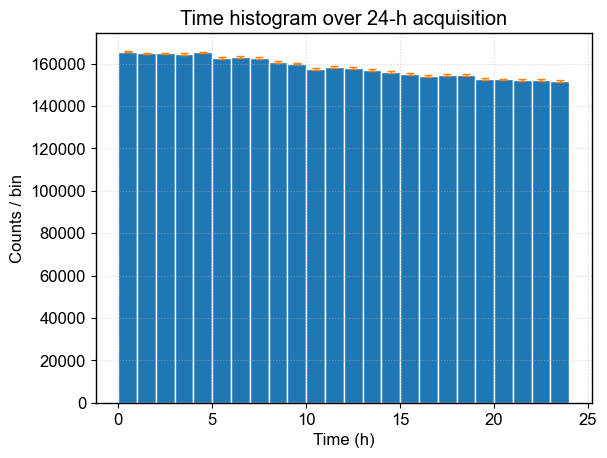

In [5]:
# regardless of what time unit you decide to use, make sure it's consistent for all arrays
thalf = 9.9 * 24 # time 
tdata = cdat.t_s / 60 / 60 # timestamps of each recorded event in hours
t_binsize = 1 # 1-hour binsize -- adjust if needed
nbins = int(np.round((tdata[-1] - tdata[0])/t_binsize))

# generate histogram
n, bins, _ = plt.hist(tdata, bins=nbins, edgecolor='white')
binedges = 0.5 * (bins[1:] + bins[:-1])

# plot the components on top of the histogram
plt.errorbar(binedges, n, np.sqrt(n), linestyle='none', capsize=3) # errorbars
plt.xlabel('Time (h)')
plt.ylabel('Counts / bin')
plt.title('Time histogram over 24-h acquisition')
plt.show()

Since the isotope decays over the course of the acquisition, the rate of event collection goes down over time. Therefore, to define (3), we need to fit the decay over the acquisition to an exponential with the half-life of the known isotope. The **y-intercept**, which is the counts per bin at time t=0 (according to iQID acquisition), is related to the activity at the start of acquisition.

### Fit the histogram with exponential decay

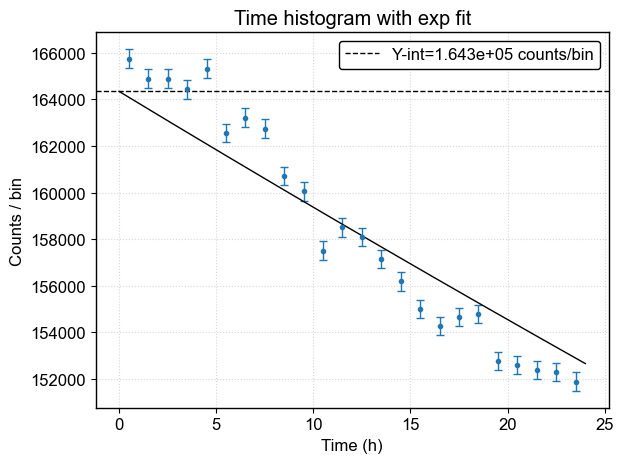

In [6]:
# fit the histogram with an exponential decay
popt, pcov, param_std, res, chisq, chisqn = cdat.fitHist(
    binedges, n, func=po.exponential, p0=[1, thalf], tol=0.05)

# generate dummy array to plot the exponential
tdummy = np.linspace(tdata[0], tdata[-1], 5000)

# plot the components on top of the histogram
plt.errorbar(binedges, n, np.sqrt(n), linestyle='none', capsize=3, marker='.') # errorbars
plt.plot(tdummy, po.exponential(tdummy, *popt), color='k')

# identify the y-intercept and plot it
yint = popt[0]
plt.axhline(yint, color='k', ls='--', label='Y-int={:.3e} counts/bin'.format(yint))

plt.xlabel('Time (h)')
plt.ylabel('Counts / bin')
plt.title('Time histogram with exp fit')
plt.legend()
plt.tight_layout()
plt.show()

### Correct the y-intercept for the binsize

<div class="alert alert-block alert-warning">
<b>Warning:</b> The actual values of the histogram, and the y-intercept, </b>will be different depending on the bin size that you select.</b> Therefore, when calculating the signal in counts per second (to convert to activity), we must <b> correct for the bin size.</b>
</div>

In [7]:
# cps = counts per second = counts / bin * bin / h * h / 3600 s
cps = yint / t_binsize / 3600 

# Use an iQID calibration to convert from cps to activity
- This calibration needs to be produced through a separate experiment.

In [8]:
cal_file = os.path.join('datdir', '..', 'data_sample', r"Sample_Ac225_cal_slope_intercept.txt")

m, b = np.genfromtxt(cal_file)
a1 = cps * m + b
print("Whole-image A1: {:.2f} Bq".format(a1))

Whole-image A1: 22.25 Bq


### Apply frame-rate and branching ratio corrections
- The need for an iQID frame rate correction is described in the Supplement here: https://doi.org/10.1038/s41598-024-70417-3
- Since the calibration data was collected at a different frame-rate setting (91 fps), one needs to be applied.

In [9]:
fps = cdat.parse_framerate()
fr_corr, _, _ = dpk.fr_corr_ac(fps)
print('Frame-rate correction factor: {:.2f}'.format(fr_corr))

Frame-rate correction factor: 1.09


### Apply decay correction to time of sample collection

In [10]:
t1 = cdat.parse_acqt()
print('iQID measurement date/time:', t1)

iQID measurement date/time: 2024-06-06 11:08:06


Suppose (for example) that the animal from which this sample was taken was euthanized at 2024/06/03 at 12:54 PM. Then that would be the time to which we correct our measurement.

In [11]:
t0 = datetime.datetime(2024, 6, 3, 12, 54, 0)
dt = iq.get_dt(t0, t1, grain='s')
dt_h = dt / 3600 # we have thalf in units of hours so adjust accordingly

# apply all corrections
a0 = a1 * fr_corr * np.exp(np.log(2) / thalf * dt_h )

print("Whole-image corrected A0: {:.2f} Bq".format(a0))

Whole-image corrected A0: 29.76 Bq


# Produce a quantitative image
- The process for this is to **assume that activity is distributed over the image according to the pixel intensity.**
- Therefore, the calculated "whole-image A0" should be split up according to how much weighting is in each pixel.

**Where might these assumptions fail?**
- If multiple isotopes are present
- If there are different ratios of progeny in different slices in the image
- If some parts of the image have sufficiently high activity to cause spatial pileup in a specific section (e.g., a very hot tissue slice, or a slide that was handled with hot gloves)
- If beta-particle emitters are used, since there is nonuniform device response
- If missed images are present

You can do this entire procedure on a ROI-by-ROI basis, as we will see in future notebooks.

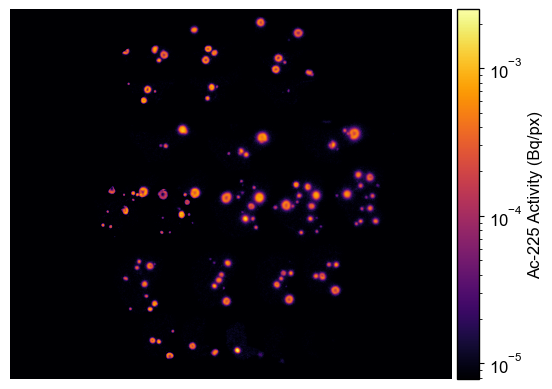

In [12]:
# normalize the image, then distribute the calculated activity by weight
cim_normed = a0 * cim / np.sum(cim)

# add threshold below which to black out in log img
small_value = np.sort(np.unique(cim_normed))[1]
im_display = np.copy(cim_normed)
im_display[im_display==0] = small_value

im = plt.imshow(im_display, cmap='inferno', norm=LogNorm())
plt.axis('off')
cbar = iq.nice_colorbar(im)
cbar.set_label('Ac-225 Activity (Bq/px)')
plt.show()